# CAPSTONE PROJECT - The Battle of Neighborhoods (Week 2)

### Coursera - IBM: Applied Data Science Capstone  ###

## Table of Contents ##
- [Introducion/Business Problem](#Introduction)
- [Data](#Data)
- [Methodology](#Methodology)
    - [Installing needed libraries](#Installation)
    - [Scrape Asian Population of Maryland Cities](#MarylandAsian)
    - [Gather Baltimore Neighborhood Data](#BaltimoreNeighborhood)
    - [Map Baltimore Neighborhood](#MapBaltimore)
    - [Exploring using Foursquare](#FourSquare)


### Introduction/Business Problem <a name="Introduction" ></a>

In this project, we will be helping an Asian Association in the USA who interested in opening an Asian Restaurant in Maryland. Financing is not an issue. However, they would like the determine which state and neighborhood in Maryland will they be targeting.

They would like to get the following information to help them with their decision:

1. Which city in the state of Maryland has the most Asian population.
2. Which neighborhood in that city has the most Asian population.
3. How many similar establishments are already in that target location.

The first two (2) items will help the company determine the target community based on population. And the third item is to determine the competition the new establishment may be facing.

We will utilize knowledge we learned on Data Science to create reports that will support the answers these questions, thus providing the association with relevant information to guide them in their venture.


### Data <a name="Data" ></a>

Based on the information being requested by the Asian Association to help them with their decision on where in Maryland will they start a new Asian Restaurant, we will need to identify the following:
1. The Asian population of each city in Maryland.
2. The Asian population of the selected city's neighborhood.
3. The number of existing Asian restaurants in the selected city's neighborhoods.

For the 1st item, we would need to get the data set containing Asian population of each city in the State in Maryland. This data can be found in url https://www.homesnacks.com/most-asian-cities-in-maryland/.  We will be needing to use BeautifulSoap to scrape the data from this website. It is important that we extract the following information: State, Asian population.

After determining which city has the most Asian population, we then move to the 2nd item in the list above.  For this part, we will once again use BeautifulSoap to scrape the information from http://www.city-data.  The following information should be availed from this site: Neighborhood, Asian population.

Once we've determined the Neighborhood, we will have to answer the 3rd item which is to identify the existing establishments in that area, thus, determining how will the business competition be like.  In this item, we will be needing __Foursquare__ location data to search and explore the venue for other Asian restaurants.

__To site an example__, if by accomplishing item no.1, we are able to know that Baltimore has the most Asian population in the state of Maryland, then, we are also able to determine that Downtown West is the neighborhood that has the most Asian population.  We will then use Foursquare data and its APIs to find out how many Asian restaurants are there is the area.  This will provide Asian Association with an overview of which neighborhood will most likely give them the best outcome when starting the Asian Restaurant. 


### Methodology <a name="Methodology" ></a>

**Installation of needed libraries**<a name="Installation"> </a>

In [1]:
#First, Let's install beautifulsoup4 for WebScraping
!pip install beautifulsoup4 

     |████████████████████████████████| 122kB 38.5MB/s eta 0:00:01


In [2]:
#Let's install geopandas for map plotting
!pip install geopandas

     |████████████████████████████████| 1.0MB 971kB/s eta 0:00:01
     |████████████████████████████████| 6.5MB 12.7MB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 39.5MB/s eta 0:00:01
     |████████████████████████████████| 15.4MB 34.6MB/s eta 0:00:01
  Found existing installation: pyproj 1.9.6
    Uninstalling pyproj-1.9.6:
      Successfully uninstalled pyproj-1.9.6


In [3]:
!pip install adjustText

  Stored in directory: /home/jupyterlab/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [4]:
#Let's install geopy
!conda install -c conda-forge geopy --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py36h5fab9bb_0         141 KB  conda-forge
    geographiclib-1.52         |     pyhd8ed1ab_0          35 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         376 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geograph

In [5]:
#Let's import the libraries

from bs4 import BeautifulSoup  #For webscraping

import lxml.html as lh
import numpy as np
import pandas as pd
import requests
import re

import folium
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize	#transform JSON file into a pandas dataframe

#Libraries for map plotting
import geopandas as gpd
import matplotlib.pyplot as plt
from adjustText import adjust_text as aT
import shapely
from shapely.geometry import Point, Polygon, LineString, GeometryCollection
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means for clustering stage
from sklearn.cluster import KMeans

**Scrape Asian Population of Maryland Cities**<a name="MarylandAsian"> </a>

In [6]:
#Define url
url = 'https://www.homesnacks.com/most-asian-cities-in-maryland/'

#Make the GET request to fetch the raw HTML content
html_content = requests.get(url).text

#Parse the HTML content using BeautifulSoap
soup = BeautifulSoup(html_content, "lxml")

#Extract the content of the table into "table".
table_contents=[]
occur=0
table=soup.find('table')

for row in table.findAll('td'):
    occur += 1
    if occur == 1:
        cell={}
    if occur == 2:
        cell['City'] = row.text
    if occur == 3:
        cell['Asian Pct'] = row.text
    if occur == 4:
        cell['Population'] = row.text
        cell['Asian Population'] = round((int(cell['Population'].replace(',','')) * float(cell['Asian Pct'].replace('%','')))/100)
        table_contents.append(cell)
        occur = 0


In [7]:
#Convert the list to dataframe
MD_df=pd.DataFrame(table_contents)
MD_df = MD_df.sort_values(by='Asian Population', ascending=False)                                ##Sort data by "Asian Population"
MD_df['Asian Population'] = MD_df.apply(lambda x: "{:,}".format(x['Asian Population']), axis=1)  ##Format displayed value for "Asian Population"
MD_df.head(5)

,City,Asian Pct,Population,Asian Population
22,Baltimore,2.57%,"609,032","15,652"
0,Rockville,20.92%,"67,542","14,130"
1,Gaithersburg,18.86%,"67,742","12,776"
2,College Park,14.43%,"32,159","4,641"
5,Frederick,6.14%,"70,887","4,352"


Based on the output above, it is seen that **Baltimore** has the most number of Asian populations amongst Maryland cities.

**Gather Baltimore Neighborhood Data** <a name="BaltimoreNeighborhood"> </a>

In [8]:
#Define url that lists the links to each neighborhood of Baltimore
url = 'http://www.city-data.com/nbmaps/neigh-Baltimore-Maryland.html'

#Make the GET request to fetch the raw HTML content
html_content = requests.get(url).text

#Parse the HTML content
soup = BeautifulSoup(html_content, "lxml")

#Extract the links of the site the table into "Baltimore_table".
Baltimore_table=[]
find_all_a = soup.find_all('a', href=True, text=re.compile("neighborhood"))  #finds all href lines that has the word "neighborhood" in its text
for row in find_all_a:
    temphtml='http://www.city-data.com'+ row['href']
    Baltimore_table.append(temphtml)

print('Baltimore Neighborhood extracted.')

Baltimore Neighborhood extracted.


In [9]:
#Let's see the content of Baltimore_table
Baltimore_table

['http://www.city-data.com/neighborhood/Abell-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Allendale-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Arcadia-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Arlington-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Armistead-Gardens-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Ashburton-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Baltimore-Linwood-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Barclay-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Barre-Circle-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Beechfield-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Belair-Edison-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Belair-Parkside-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Bellona-Gittings-Baltimore-MD.html',
 'http://www.city-data.com/neighborhood/Berea-Baltimore-MD.ht

In [10]:
#Now, let's go through each record in Baltimore_table to access each site.
Baltimore_stats = []

# We will need the following information: neighborhood, population, percentage
for row in Baltimore_table:
    url = row  #assign url
    
    #Make the GET request to fetch the raw HTML content
    html_content = requests.get(url).text
    
    #Parse the HTML content using BeautifulSoap
    soup = BeautifulSoup(html_content, "lxml")

    cell={}
    find_all_li = soup.find_all('li', {'class': re.compile("raceDist")})  #finds all href lines that has the word "neighborhood" in its text
    for row2 in find_all_li:
        for row3 in row2.find_all('li', class_= re.compile("list-group-item")):
            if row3.b.text == 'Asian':
                cell['Neighborhood'] = soup.find('h1').span.text.split(' neighborhood')[0]
                cell['Population'] = row3.find('span',{'class': 'badge'}).text
                cell['Percentage'] = row3.find('span',{'class': 'badge alert-info'}).text
                Baltimore_stats.append(cell)

##Let's see the content of Baltimore_stats
Baltimore_stats

[{'Neighborhood': 'Abell', 'Population': '33', 'Percentage': '3.0%'},
 {'Neighborhood': 'Arcadia', 'Population': '7', 'Percentage': '0.6%'},
 {'Neighborhood': 'Arlington', 'Population': '13', 'Percentage': '0.6%'},
 {'Neighborhood': 'Armistead Gardens',
  'Population': '109',
  'Percentage': '3.3%'},
 {'Neighborhood': 'Ashburton', 'Population': '73', 'Percentage': '1.8%'},
 {'Neighborhood': 'Baltimore-Linwood',
  'Population': '268',
  'Percentage': '3.5%'},
 {'Neighborhood': 'Barclay', 'Population': '66', 'Percentage': '1.6%'},
 {'Neighborhood': 'Barre Circle', 'Population': '7', 'Percentage': '2.4%'},
 {'Neighborhood': 'Beechfield', 'Population': '33', 'Percentage': '0.8%'},
 {'Neighborhood': 'Belair-Edison', 'Population': '213', 'Percentage': '1.0%'},
 {'Neighborhood': 'Belair-Parkside', 'Population': '1', 'Percentage': '0.9%'},
 {'Neighborhood': 'Bellona-Gittings',
  'Population': '10',
  'Percentage': '1.9%'},
 {'Neighborhood': 'Berea', 'Population': '35', 'Percentage': '0.6%'},
 

In [11]:
#Convert list to dataframe
Baltimore_stats_df = pd.DataFrame(Baltimore_stats)
Baltimore_stats_df.columns = ['Neighborhood','AsianPopulation','AsianPercentage']

#Clean data by removing comma in the AsianPopulation field and converting it to integer
Baltimore_stats_df['AsianPopulation'] = Baltimore_stats_df['AsianPopulation'].str.replace(',','').astype(int)

In [12]:
#Let's import Baltimore's map shape file
fp = "./Maryland_Baltimore_City_Neighborhoods.shp"
map_df = gpd.read_file(fp)

In [13]:
# merge the map_df and Baltimore_stats_df
merged = map_df.merge(Baltimore_stats_df, how='outer', left_on="LABEL", right_on="Neighborhood")

merged.head()

,OBJECTID,NBRDESC,ACRES,LABEL,COLOR_2,geometry,Neighborhood,AsianPopulation,AsianPercentage
0,1.0,ABELL,46.710432,Abell,2.0,"POLYGON ((1422345.337 603620.765, 1422192.136 ...",Abell,33.0,3.0%
1,2.0,ALLENDALE,260.023864,Allendale,2.0,"POLYGON ((1404989.665 592042.050, 1404989.913 ...",NaN,NaN,NaN
2,3.0,ARCADIA,144.678075,Arcadia,2.0,"POLYGON ((1434376.830 608229.661, 1434486.755 ...",Arcadia,7.0,0.6%
3,4.0,ARLINGTON,115.584689,Arlington,5.0,"POLYGON ((1401059.486 612450.588, 1401004.764 ...",Arlington,13.0,0.6%
4,5.0,ARMISTEAD GARDENS,302.585653,Armistead Gardens,2.0,"POLYGON ((1437179.460 597502.829, 1437145.202 ...",Armistead Gardens,109.0,3.3%


In [14]:
#let's clean the DATA.

#First check if there are with NaN values
merged[merged.isna().any(axis=1)]

,OBJECTID,NBRDESC,ACRES,LABEL,COLOR_2,geometry,Neighborhood,AsianPopulation,AsianPercentage
1,2.0,ALLENDALE,260.023864,Allendale,2.0,"POLYGON ((1404989.665 592042.050, 1404989.913 ...",NaN,NaN,NaN
6,7.0,BALTIMORE HIGHLANDS,96.967070,Baltimore Highlands,4.0,"POLYGON ((1434162.643 593039.546, 1434161.443 ...",NaN,NaN,NaN
7,8.0,PATTERSON PARK NEIGHBORHOOD,108.112661,Patterson Park Neighborhood,2.0,"POLYGON ((1433312.950 593229.199, 1433451.437 ...",NaN,NaN,NaN
19,20.0,BOYD-BOOTH,24.788620,Boyd-Booth,2.0,"POLYGON ((1410967.395 590094.986, 1410889.771 ...",NaN,NaN,NaN
21,22.0,BRIDGEVIEW/GREENLAWN,181.313308,Bridgeview/Greenlawn,1.0,"POLYGON ((1410406.082 594500.536, 1410416.185 ...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
303,NaN,NaN,NaN,NaN,NaN,None,Old Town,122.0,0.7%
304,NaN,NaN,NaN,NaN,NaN,None,Panway (Braddish Avenue),10.0,0.9%
305,NaN,NaN,NaN,NaN,NaN,None,Penrose,28.0,0.9%
306,NaN,NaN,NaN,NaN,NaN,None,Pimlico,62.0,2.7%


**Some of the data failed to merge because of the LABELs and Neighborhoods fields did not match perfectly.
To solve this, create a routine to go through the merged dataframe and scan the Baltimore_stats_df's Neighboorhood field with similar names.**

In [15]:
#Create a routine to cleanup the data

delim=['/','-',' ']  #delimiters used in merged dataframe.  This will be used to split the words in the LABEL field.

for index, row in merged.iterrows():
    row = row.copy()
    try:
        if row['LABEL'] > '':
            print('processing: ', row['LABEL'])
            if row['LABEL'] == row['Neighborhood']:
                pass
            else:
                if np.isnan(row['Neighborhood']) or np.isnan(row['AsianPopulation']) or np.isnan(row['AsianPercentage']):
                    for i, item in enumerate(delim):
                        x = row['LABEL'].split(item)
                        if len(x) > 0:
                            if len(x) == 3:
                                temp = Baltimore_stats_df.loc[Baltimore_stats_df['Neighborhood'].str.contains(x[0]) & Baltimore_stats_df['Neighborhood'].str.contains(x[1]) & Baltimore_stats_df['Neighborhood'].str.contains(x[2])]
                            if len(x) == 2:
                                temp = Baltimore_stats_df.loc[Baltimore_stats_df['Neighborhood'].str.contains(x[0]) & Baltimore_stats_df['Neighborhood'].str.contains(x[1])]
                            if len(x) == 1:
                                temp = Baltimore_stats_df.loc[Baltimore_stats_df['Neighborhood'].str.contains(x[0])]
                            if temp.empty:
                                pass
                            else:
                                if len(temp) == 1:  #Only one record was returnd
                                    merged.at[index, "Neighborhood"] = row[index, "LABEL"]
                                    merged.at[index, "AsianPopulation"] = temp["AsianPopulation"]
                                    merged.at[index, "AsianPercentage"] = temp["AsianPercentage"]
                                    break
                    if temp.empty or len(temp) > 1:
                        print('No Neighborhood found. LABEL deleted')
                        merged.drop(index, inplace=True)
                    else:    
                        print('Neighborhood updated to:', row["LABEL"])
    except:
        pass

merged.dropna(axis=0, inplace=True)  #remove all rows that still have NaN values..

processing:  Abell
processing:  Allendale
No Neighborhood found. LABEL deleted
processing:  Arcadia
processing:  Arlington
processing:  Armistead Gardens
processing:  Ashburton
processing:  Baltimore Highlands
No Neighborhood found. LABEL deleted
processing:  Patterson Park Neighborhood
No Neighborhood found. LABEL deleted
processing:  Barclay
processing:  Barre Circle
processing:  Beechfield
processing:  Belair-Parkside
processing:  Bellona-Gittings
processing:  Berea
processing:  Better Waverly
processing:  Beverly Hills
processing:  Biddle Street
processing:  Blythewood
processing:  Bolton Hill
processing:  Boyd-Booth
processing:  Brewers Hill
processing:  Bridgeview/Greenlawn
processing:  Broadway East
processing:  Broening Manor
processing:  Brooklyn
No Neighborhood found. LABEL deleted
processing:  Burleith-Leighton
No Neighborhood found. LABEL deleted
processing:  Butcher's Hill
processing:  Callaway-Garrison
processing:  Cameron Village
processing:  Canton
processing:  Canton I

In [16]:
#Let's check again if there are still rows with NaN values
merged[merged.isna().any(axis=1)]

,OBJECTID,NBRDESC,ACRES,LABEL,COLOR_2,geometry,Neighborhood,AsianPopulation,AsianPercentage


**Map Baltimore Neighborhood** <a name="MapBaltimore"> </a>

In [17]:
#Now, get the centroid of each location
merged['center'] = merged['geometry'].centroid
merged_points = merged.copy()
merged_points.set_geometry("center", inplace = True)

In [18]:
merged_points

,OBJECTID,NBRDESC,ACRES,LABEL,COLOR_2,geometry,Neighborhood,AsianPopulation,AsianPercentage,center
0,1.0,ABELL,46.710432,Abell,2.0,"POLYGON ((1422345.337 603620.765, 1422192.136 ...",Abell,33.0,3.0%,POINT (1422266.863 604534.066)
2,3.0,ARCADIA,144.678075,Arcadia,2.0,"POLYGON ((1434376.830 608229.661, 1434486.755 ...",Arcadia,7.0,0.6%,POINT (1434603.725 607469.517)
3,4.0,ARLINGTON,115.584689,Arlington,5.0,"POLYGON ((1401059.486 612450.588, 1401004.764 ...",Arlington,13.0,0.6%,POINT (1402055.725 612718.466)
4,5.0,ARMISTEAD GARDENS,302.585653,Armistead Gardens,2.0,"POLYGON ((1437179.460 597502.829, 1437145.202 ...",Armistead Gardens,109.0,3.3%,POINT (1439257.445 597835.344)
5,6.0,ASHBURTON,225.555236,Ashburton,3.0,"POLYGON ((1404374.743 604165.231, 1404114.311 ...",Ashburton,73.0,1.8%,POINT (1405203.525 605298.807)
...,...,...,...,...,...,...,...,...,...,...
209,210.0,ROLAND PARK,612.795699,Roland Park,4.0,"POLYGON ((1415827.424 614397.662, 1415867.341 ...",Roland Park,389.0,7.6%,POINT (1415273.148 613246.973)
210,211.0,ROSEBANK,42.329316,Rosebank,3.0,"POLYGON ((1422615.548 618445.529, 1422615.341 ...",Rosebank,5.0,1.2%,POINT (1422111.952 617991.889)
211,212.0,ROSEMONT,111.471360,Rosemont,4.0,"POLYGON ((1406293.308 595787.350, 1406005.454 ...",Rosemont,9.0,0.3%,POINT (1405562.588 596629.445)
274,275.0,BELAIR-EDISON,527.968507,Belair-Edison,1.0,"POLYGON ((1432204.448 603179.733, 1432106.992 ...",Belair-Edison,213.0,1.0%,POINT (1434614.080 602667.624)


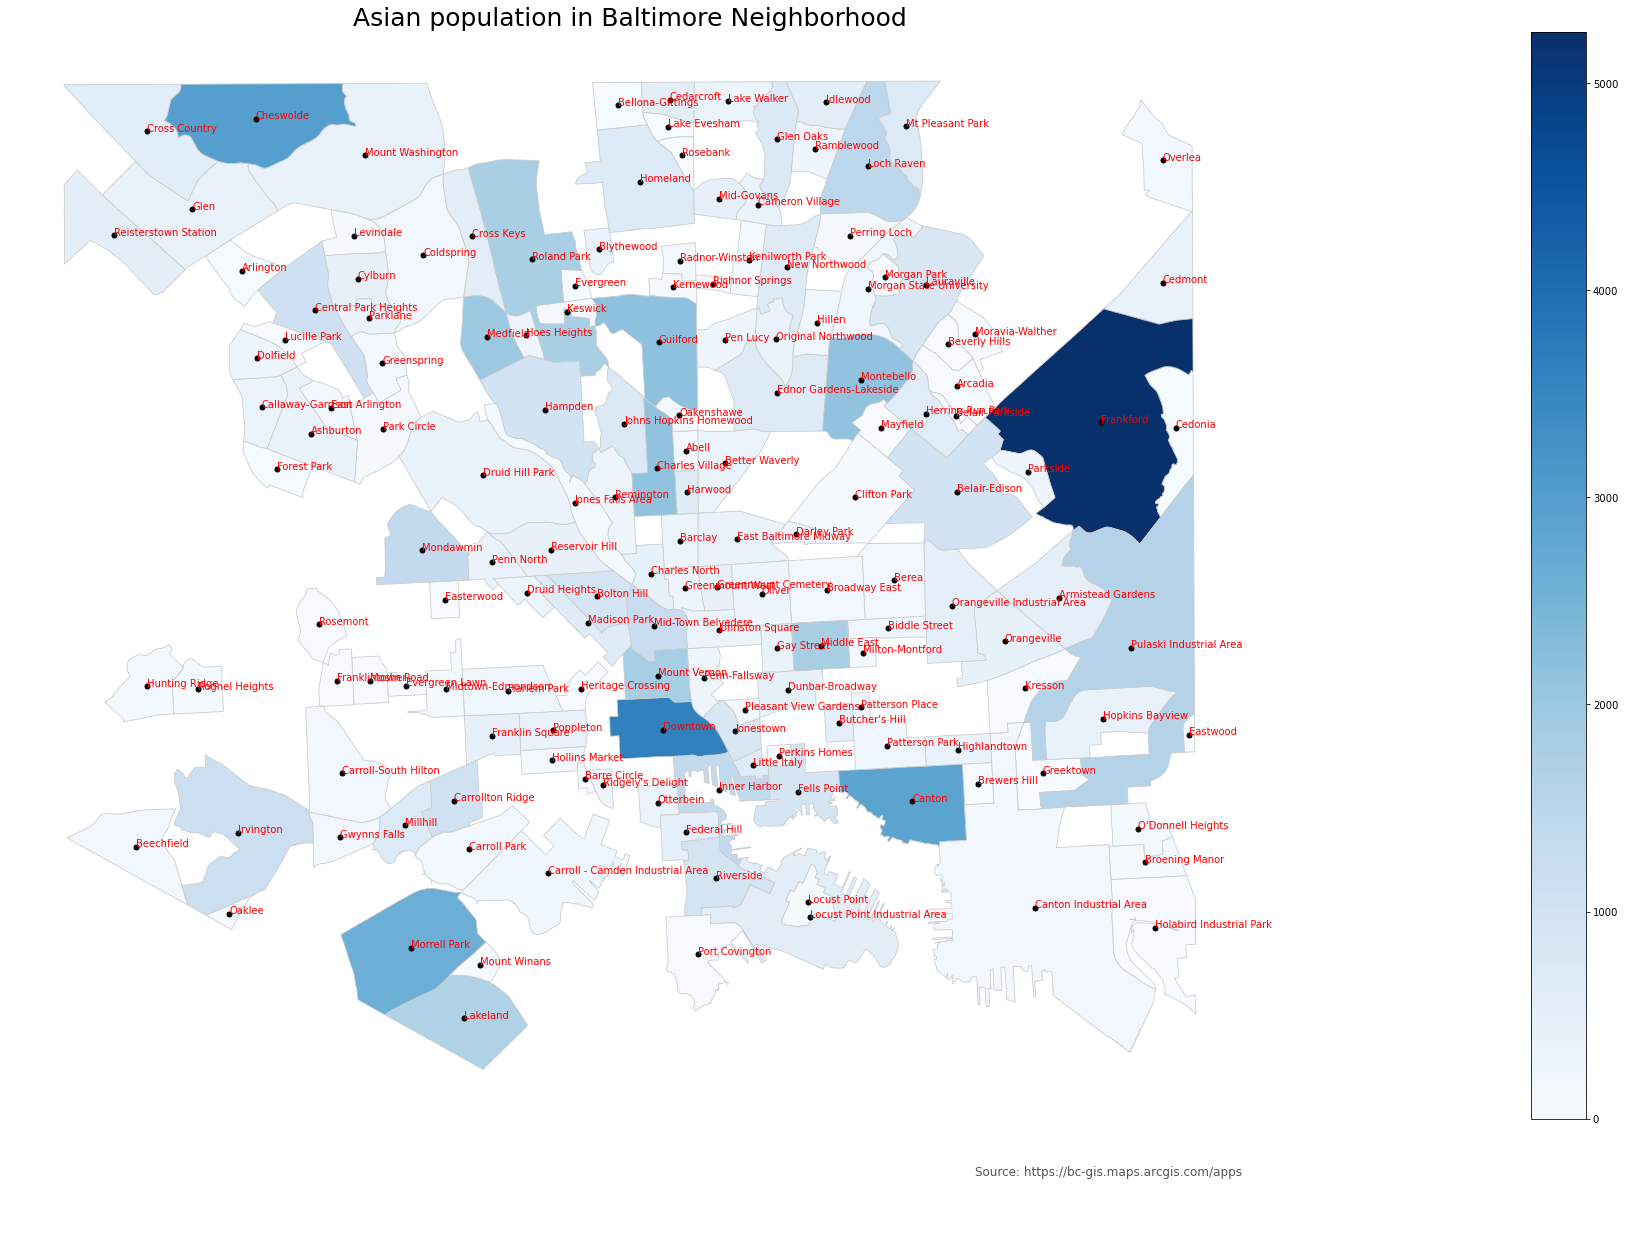

In [19]:
from adjustText import adjust_text as adjt

# check the GeoDataframe
plt.rcParams['figure.figsize'] = [50,100] #height, width

# set the value column that will be visualised
variable = 'AsianPopulation'

# set the range for the choropleth values
vmin, vmax = 0, Baltimore_stats_df["AsianPopulation"].max()

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(100, 20))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title('Asian population in Baltimore Neighborhood', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: https://bc-gis.maps.arcgis.com/apps', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it

# add the colorbar to the figure
fig.colorbar(sm)

# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
texts = []

for x, y, label in zip(merged_points.geometry.x, merged_points.geometry.y, merged_points["LABEL"]):
    texts.append(plt.text(x, y, label, fontsize = 10, color='red'))
    plt.plot(x,y,'ok', markersize=5 )


**Based on the figure above, FrankFord neighborhood in Baltimore has the most number of Asian population.  It is also surrounded by other neighborhoods which have considerable Asian populations as well, like Pulaski Industrial area, Belaire-Edison.**

**Now, let us explore the neighborhood of FrankFord.**

**Exploring using Foursquare** <a name="FourSquare"> </a>

In [20]:
#Define Foursquare Credentials
CLIENT_ID='FXIGGFYXJ0F2WYJAIK5BWRQPNVNOCHSB5DSLAVYZM3FYZSYD'        #Foursquare ID
CLIENT_SECRET='UBPUPBMGHTTXBNIOO5XTM2NRZ1B5UY251OP3GN01FIJTNPNM'    #Foursquare Secret
ACCESS_TOKEN='DYEESP4IBFCOC5B0LEFIMFTF1HTH5CDDIVGL1QCKDWODIJCF'     #Your Foursquare Access Token
VERSION='20180604'
LIMIT=30

In [21]:
# Get the geographical coordinates of FrankFord Baltimore
address = 'FrankFord Baltimore, MD'

geolocator = Nominatim(user_agent="md_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of FrankFord Baltimore, MD are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of FrankFord Baltimore, MD are 39.3289004, -76.5473002.


In [22]:
#let's now concentrate on 'Asian' establishments within FrankFord neighborhood in Baltimore.

search_query = 'Asia'
radius = 4000  ## in meters
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=FXIGGFYXJ0F2WYJAIK5BWRQPNVNOCHSB5DSLAVYZM3FYZSYD&client_secret=UBPUPBMGHTTXBNIOO5XTM2NRZ1B5UY251OP3GN01FIJTNPNM&ll=39.3289004,-76.5473002&oauth_token=DYEESP4IBFCOC5B0LEFIMFTF1HTH5CDDIVGL1QCKDWODIJCF&v=20180604&query=Asia&radius=4000&limit=30'

In [23]:
#Next, get the request and examine the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60e79a83d7ae7f359f0cbb05'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '4cc486fb3d7fa1cd7f7bac5f',
    'name': 'Asian Taste',
    'location': {'address': '5443 Belair Rd',
     'lat': 39.339024,
     'lng': -76.54985,
     'labeledLatLngs': [{'label': 'display',
       'lat': 39.339024,
       'lng': -76.54985}],
     'distance': 1148,
     'postalCode': '21206',
     'cc': 'US',
     'city': 'Baltimore',
     'state': 'MD',
     'country': 'United States',
     'formattedAddress': ['5443 Belair Rd', 'Baltimore, MD 21206']},
    'categories': [{'id': '4bf58dd8d48988d142941735',
      'name': 'Asian Restaurant',
      'pluralName': 'Asian Restaurants',
      'shortName': 'Asian',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
       'suffix': '.png'},
      'primary': True}],
    'delivery': {'id': '300357',
     'url': 'https://www.grubhub.com/restaura

In [24]:
#Get the relevant part of JSON

venues = results['response']['venues']
Asian_Estab = json_normalize(venues) # flatten JSON
Asian_Estab.head(10)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in Asian_Estab.columns if col.startswith('location.')] + ['id']
Asian_Estab_filtered = Asian_Estab.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
Asian_Estab_filtered['categories'] = Asian_Estab_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
Asian_Estab_filtered.columns = [column.split('.')[-1] for column in Asian_Estab_filtered.columns]

Asian_Estab_filtered

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Asian Taste,Asian Restaurant,5443 Belair Rd,39.339024,-76.549850,"[{'label': 'display', 'lat': 39.339024, 'lng':...",1148,21206,US,Baltimore,MD,United States,"[5443 Belair Rd, Baltimore, MD 21206]",NaN,4cc486fb3d7fa1cd7f7bac5f
1,HaHa Food,Grocery Store,7501 Pulaski Hwy,39.311243,-76.525020,"[{'label': 'display', 'lat': 39.31124283384103...",2746,21237,US,Rosedale,MD,United States,"[7501 Pulaski Hwy (at 66th St), Rosedale, MD 2...",at 66th St,4c9a6ec49c663704269058fd
2,Asiatic's Cutz Barber Shop,Salon / Barbershop,1560 Havenwood Rd,39.341135,-76.590481,"[{'label': 'display', 'lat': 39.34113539402315...",3959,21218,US,Baltimore,MD,United States,"[1560 Havenwood Rd (btwn Hillen & Loch Raven),...",btwn Hillen & Loch Raven,4b2c157df964a5203bc124e3


In [25]:
#Let's visualize where these establishments are
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Frankford neighborhood

# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup=address,
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Asian establishments as blue circle markers
for lat, lng, label in zip(Asian_Estab_filtered.lat, Asian_Estab_filtered.lng, Asian_Estab_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

**As seen, there is only one Asian restaurant in the vicinity.**

**Let's try exploring Asian Taste Restaurant**

In [26]:
#Let's explore the surrounding venues of the Asian Taste Neighborhood

venue_id = '4cc486fb3d7fa1cd7f7bac5f' # ID of Asian Taste restaurant
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
url

'https://api.foursquare.com/v2/venues/4cc486fb3d7fa1cd7f7bac5f?client_id=FXIGGFYXJ0F2WYJAIK5BWRQPNVNOCHSB5DSLAVYZM3FYZSYD&client_secret=UBPUPBMGHTTXBNIOO5XTM2NRZ1B5UY251OP3GN01FIJTNPNM&oauth_token=DYEESP4IBFCOC5B0LEFIMFTF1HTH5CDDIVGL1QCKDWODIJCF&v=20180604'

In [27]:
result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'price', 'hasMenu', 'likes', 'like', 'dislike', 'ok', 'delivery', 'menu', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'seasonalHours', 'pageUpdates', 'inbox', 'attributes'])


{'id': '4cc486fb3d7fa1cd7f7bac5f',
 'name': 'Asian Taste',
 'contact': {'phone': '4103251000', 'formattedPhone': '(410) 325-1000'},
 'location': {'address': '5443 Belair Rd',
  'lat': 39.339024,
  'lng': -76.54985,
  'labeledLatLngs': [{'label': 'display', 'lat': 39.339024, 'lng': -76.54985}],
  'postalCode': '21206',
  'cc': 'US',
  'city': 'Baltimore',
  'state': 'MD',
  'country': 'United States',
  'formattedAddress': ['5443 Belair Rd', 'Baltimore, MD 21206']},
 'canonicalUrl': 'https://foursquare.com/v/asian-taste/4cc486fb3d7fa1cd7f7bac5f',
 'categories': [{'id': '4bf58dd8d48988d142941735',
   'name': 'Asian Restaurant',
   'pluralName': 'Asian Restaurants',
   'shortName': 'Asian',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
    'suffix': '.png'},
   'primary': True}],
 'verified': False,
 'stats': {'tipCount': 0},
 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'},
 'hasMenu': True,
 'likes': {'count': 0, 'groups': []},
 'like': False,


In [28]:
#Let's check the rating of Asian Taste
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


**It appears that this restaurant has not been reviewed yet.**

**Now, let's explore of Frankford neighborhood**

In [29]:
#let's explore the are of Frank Fordford neighborhood

radius = 4000  ## in meters
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=FXIGGFYXJ0F2WYJAIK5BWRQPNVNOCHSB5DSLAVYZM3FYZSYD&client_secret=UBPUPBMGHTTXBNIOO5XTM2NRZ1B5UY251OP3GN01FIJTNPNM&ll=39.3289004,-76.5473002&v=20180604&radius=4000&limit=30'

In [30]:
#Let's get the result of the url
results = requests.get(url).json()
'There are {} within Frankford neighborhood.'.format(len(results['response']['groups'][0]['items']))

'There are 30 within Frankford neighborhood.'

In [31]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4b5732abf964a5209b2a28e3',
  'name': 'Woodlea Bakery',
  'location': {'address': '4905 Belair Rd',
   'lat': 39.334610818105666,
   'lng': -76.55651687718685,
   'labeledLatLngs': [{'label': 'display',
     'lat': 39.334610818105666,
     'lng': -76.55651687718685},
    {'label': 'entrance', 'lat': 39.334558, 'lng': -76.556542}],
   'distance': 1016,
   'postalCode': '21206',
   'cc': 'US',
   'city': 'Baltimore',
   'state': 'MD',
   'country': 'United States',
   'formattedAddress': ['4905 Belair Rd',
    'Baltimore, MD 21206',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d16a941735',
    'name': 'Bakery',
    'pluralName': 'Bakeries',
    'shortName': 'Bakery',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0

In [32]:
FrankFord_df = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in FrankFord_df.columns if col.startswith('venue.location.')] + ['venue.id']
FrankFord_df_filtered = FrankFord_df.loc[:, filtered_columns]

# filter the category for each row
FrankFord_df_filtered['venue.categories'] = FrankFord_df_filtered.apply(get_category_type, axis=1)

# clean columns
FrankFord_df_filtered.columns = [col.split('.')[-1] for col in FrankFord_df_filtered.columns]

FrankFord_df_filtered.head(30)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Woodlea Bakery,Bakery,4905 Belair Rd,39.334611,-76.556517,"[{'label': 'display', 'lat': 39.33461081810566...",1016,21206,US,Baltimore,MD,United States,"[4905 Belair Rd, Baltimore, MD 21206, United S...",NaN,4b5732abf964a5209b2a28e3
1,Aldi food market,Grocery Store,4212 Frankford Ave,39.337785,-76.550497,"[{'label': 'display', 'lat': 39.33778471832159...",1026,21206,US,Baltimore,MD,United States,"[4212 Frankford Ave (5400 bel air rd.), Baltim...",5400 bel air rd.,4c275feba852c9284919e86c
2,Zeke's Coffee (retail),Coffee Shop,4607 Harford Rd,39.342333,-76.569978,"[{'label': 'display', 'lat': 39.34233267656300...",2459,21214,US,Baltimore,MD,United States,"[4607 Harford Rd (Grindon Ave.), Baltimore, MD...",Grindon Ave.,4b9502e9f964a520808b34e3
3,Koco's Pub,Seafood Restaurant,4301 Harford Rd,39.338625,-76.573334,"[{'label': 'display', 'lat': 39.33862519046768...",2489,21214,US,Baltimore,MD,United States,"[4301 Harford Rd (at Weaver Ave), Baltimore, M...",at Weaver Ave,4b2b9cdff964a5203cb824e3
4,Dollar General,Discount Store,4810 Belair Rd,39.334164,-76.558022,"[{'label': 'entrance', 'lat': 39.333839, 'lng'...",1093,21206,US,Baltimore,MD,United States,"[4810 Belair Rd, Baltimore, MD 21206, United S...",NaN,4dd57f81bd41965192d1494d
5,Subway,Sandwich Place,5112 Sinclair Ln,39.324537,-76.545355,"[{'label': 'display', 'lat': 39.3245365, 'lng'...",513,21206,US,Baltimore,MD,United States,[5112 Sinclair Ln (in Parkside Shopping Center...,in Parkside Shopping Center,4c6fe75d344437040447225f
6,The Red Canoe,Bookstore,4337 Harford Rd,39.339434,-76.572701,"[{'label': 'display', 'lat': 39.33943404389466...",2481,21214,US,Baltimore,MD,United States,"[4337 Harford Rd, Baltimore, MD 21214, United ...",NaN,4b435f03f964a52010df25e3
7,Maggie's Farm,New American Restaurant,4341 Harford Rd,39.339445,-76.572431,"[{'label': 'display', 'lat': 39.33944458747611...",2461,21214,US,Baltimore,MD,United States,"[4341 Harford Rd (at Montebello Ter), Baltimor...",at Montebello Ter,50a92c25498ea24de189e4a5
8,Hazelwood Inn,American Restaurant,4937 Hazelwood Ave,39.340288,-76.524650,"[{'label': 'display', 'lat': 39.34028793200447...",2325,21206,US,Baltimore,MD,United States,"[4937 Hazelwood Ave, Baltimore, MD 21206, Unit...",NaN,4b47f488f964a5200e4526e3
9,Blake's Crab House,Seafood Restaurant,5005 Erdman Ave,39.305810,-76.558289,"[{'label': 'display', 'lat': 39.30581000148488...",2739,21205,US,Baltimore,MD,United States,"[5005 Erdman Ave, Baltimore, MD 21205, United ...",NaN,4c59be20f346c9284a554dca


In [33]:
#Let's visualize the popular establishments.

venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Frankford neighborhood

# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup=address,
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the explored venues as yellow circle markers
for lat, lng, label in zip(FrankFord_df_filtered['lat'], FrankFord_df_filtered['lng'], FrankFord_df_filtered['name']):
    folium.CircleMarker(
            [lat, lng],
            radius=8,
            poup=label,
            fill=True,
            color='orange',
            fill_color='orange',
            fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

**The 30 venues shown above indicates that within the 4000 meters radius from the center of the Frankford neighborhood, there are other restaurants from Italian to Seafood restaurants. There are also coffee shops, bakeshops, grocery stores and gyms.  This neighborhood has a good distribution of establishments, indicating that is not a bad place to start a business.**

**Now, let's try finding some trending places**

In [34]:
#let's now concentrate on trending places around Baltimore area

url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION)

#Next, get the request and examine the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60e79ac35a3c3a19794fd7ce'},
 'response': {'venues': []}}

In [35]:
#Check if any venues are trending at this time
trending_msg=' '
if len(results['response']['venues']) == 0:
    trending_venues_df = 'No trending venues are available at the moment!'
    trending_msg = 'Cannot generate visual as no trending venues are available at the moment!'
else:
    trending_venues = results['response']['venues']
    trending_venues_df = json_normalize(trending_venues)

    # filter columns
    columns_filtered = ['name', 'categories'] + ['location.distance', 'location.city', 'location.postalCode', 'location.state', 'location.country', 'location.lat', 'location.lng']
    trending_venues_df = trending_venues_df.loc[:, columns_filtered]

    # filter the category for each row
    trending_venues_df['categories'] = trending_venues_df.apply(get_category_type, axis=1)


In [36]:
#Display trending venues
#Display trending venues
if trending_msg == ' ':
    trending_venues_df
else:
    print(trending_msg)

Cannot generate visual as no trending venues are available at the moment!


**Let's check the map**

In [37]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Frankford neighborhood

# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup=address,
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the trending venues as blue circle markers
if trending_msg == ' ':
    for lat, lng, label in zip(trending_venues_df['location.lat'], trending_venues_df['location.lng'], trending_venues_df['name']):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            poup=label,
            fill=True,
            color='purple',
            fill_color='purple',
            fill_opacity=0.6
        ).add_to(venues_map)
        
# display map
venues_map

**As a conclusion, Frankford Neighborhood has the most Asian population and there is only one Asian restaurant in the area. This restaurant has not been rated and would not appear as a tough competitor. Frankford neighborhood also show a promising opportunity to start business as it currently have diverse establishments indicating that this place is also being targetted by other investors. Thus, a new Asian restaurant may be a promising venture in this neighborhood** 

**This is the end of this notebook**